# Can we find zero in less than 20 iterations ?
## The Quest for the Ultimate Optimizer - Episode 2
-------------------------------------------------------------------

This notebook is a continuation of the first episode of my Quest for the Ultimate Optimizer series of notebooks, which was inspired by DeepMind’s paper [“Learning to learn by gradient descent by gradient descent”](https://arxiv.org/abs/1606.04474) and [Llion Jones's article on this paper](https://hackernoon.com/learning-to-learn-by-gradient-descent-by-gradient-descent-4da2273d64f2). I encourage you to read all of these if you want to understand how the following is set-up.

Being a continuation of the first episode, it contains quite a lot of setting-up that comes directly from it, and that I have positionned at the end to avoid repeating myself too much. This means that:
1. If you want to run this notebook, you need to start by running the appendix at the end before the rest of the notebook
2. If you haven't read the first notebook yet, go check it out, this one will make more sense if you start there.

### Appendix

I'll start with the same disclaimer as in the first notebook : the code in this section draws heavily from [Llion Jones's article](https://hackernoon.com/learning-to-learn-by-gradient-descent-by-gradient-descent-4da2273d64f2).  
I encourage you to read, it if you want to understand how it is set-up.
For the rest you'll find a bit more explanations in the first notebook.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

In [2]:
# If you have tensorflow for GPU but want to use your CPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [3]:
DIMS = 2  # Dimensions of the quadratic function, the simplest application problem in DeepMind's paper
scale = tf.random_uniform([DIMS], 0.5, 1.5)
# The scale vector gives a different shape to the quadratic function at each initialization 
def quadratic(x):
  x = scale*x
  return tf.reduce_sum(tf.square(x))

In [4]:
# Some reference optimizers for benchmarking

def g_sgd(gradients, state, learning_rate=0.1):
  # Vanilla Stochastic Gradient Descent
  return -learning_rate*gradients, state

def g_rms(gradients, state, learning_rate=0.1, decay_rate=0.99):
  # RMSProp
  if state is None:
    state = tf.zeros(DIMS)
  state = decay_rate*state + (1-decay_rate)*tf.pow(gradients, 2)
  update = -learning_rate*gradients / (tf.sqrt(state)+1e-5)
  return update, state

In [5]:
TRAINING_STEPS = 20  # This is 100 in the paper

initial_pos = tf.random_uniform([DIMS], -1., 1.)

def learn(optimizer):
  losses = []
  x = initial_pos
  state = None
  # The loop below unrolls the 20 steps of the optimizer into a single tensorflow graph
  for _ in range(TRAINING_STEPS):
    loss = quadratic(x)
    losses.append(loss)
    grads, = tf.gradients(loss, x)
    update, state = optimizer(grads, state)
    x += update
  return losses

In [6]:
sgd_losses = learn(g_sgd)
rms_losses = learn(g_rms)

In [7]:
# Now let's define the RNN optimizer
LAYERS = 2
STATE_SIZE = 20

cell = tf.contrib.rnn.MultiRNNCell(
  [tf.contrib.rnn.LSTMCell(STATE_SIZE) for _ in range(LAYERS)])
cell = tf.contrib.rnn.InputProjectionWrapper(cell, STATE_SIZE)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, 1)
cell = tf.make_template('cell', cell)

In [8]:
def optimize(loss, learning_rate=0.1):
  # "Meta optimizer" to be applied on the RNN defined above
  optimizer = tf.train.AdamOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.)
  return optimizer.apply_gradients(zip(gradients, v))

In [9]:
def print_dict(*args):
  # Prints variables in a dict format for easier reading
  dict_name = dict((name,eval(name)) for name in args)
  print(dict_name)

In [10]:
def graph_optimizers(f1, f2, f3, it=3, training_steps=TRAINING_STEPS):
  # Graph to compare RNN to the 2 baseline optimizers
  x = np.arange(training_steps)
  for _ in range(it): 
    sgd_l, rms_l, rnn_l = sess.run([f1, f2, f3])
    p1, = plt.semilogy(x, sgd_l, label='SGD')
    p2, = plt.semilogy(x, rms_l, label='RMS')
    p3, = plt.semilogy(x, rnn_l, label='RNN')
    plt.legend(handles=[p1, p2, p3])
    plt.title('Losses')
    plt.show()

In [11]:
def rolling_log_average(array, L):
  # Rolling average of the log of the array over a length of L
  rolling_av = np.array([])
  for i in range(array.size):
    rolling_av = np.append(rolling_av, 10**(np.log10(array[:i+1][-L:] + 1e-38).mean()))
  return rolling_av

In [12]:
import warnings
def draw_convergence(*args):
  """Draws the convergence of one or several meta optimizations
  transparent area is the raw results, the plain line is the 500 rolling 'log average'"""
  it = 0
  for f in args:
    it = max(eval(f).size, it)
  handles = []
  for f in args:
    flist = eval(f)[np.logical_not(np.isnan(eval(f)))] #removes NaN
    flist_rolling = rolling_log_average(flist, 500)
    flist_size = flist.size
    #matplotlib doesn't like graphs of different length so we fill the shorter graphs with None
    if flist_size < it:
      flist = np.append(flist, [None]*(it-flist_size))
      flist_rolling = np.append(flist_rolling, [None]*(it-flist_size))
    c1, = plt.semilogy(range(it), flist, alpha=0.3)
    c2, = plt.semilogy(range(it), flist_rolling, color=c1.get_color(), label=f)
    handles = handles + [c2]
  plt.legend(handles=handles)
  plt.title('End result of the optimizer')
  #matplotlib still doesn't like graphs of different length so we filter associated warnings
  warnings.filterwarnings("ignore",category =RuntimeWarning)
  plt.show()

In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

### Recap of the previous episode

In the first notebook, we reused [Llion Jones's implementation](https://hackernoon.com/learning-to-learn-by-gradient-descent-by-gradient-descent-4da2273d64f2) of [“Learning to learn by gradient descent by gradient descent”](https://arxiv.org/abs/1606.04474) which set-up a RNN (recurrent neural network) in tensorflow for use as an optimizer that works similarly to SGD or RMSProp, then unrolls 20 of its iterations (we'll call those the "base" iterations) within a single tensorflow graph so that we can iteratively  modify the parameters of the RNN to minimize the result, thus optimizing the RNN optimizer (we'll call those the "meta" iterations).

The target was to beat RMSProp performance on the most simple problem you can think of : find the zero of a 2 dimension quadratic function.  
To do that we tweaked a little bit the objective function to avoid the problem of vanishing gradient as the RNN gets better, finally settling on log of the RNN result as our objective function to minimize.
We also implemented what I will describe as a "liberal" interpretation of the preprocessing scheme for the RNN  proposed in DeepMind's paper which is basically to also apply the log function on the gradients of the quadritic function before feeding the result into the RNN.

Let's re-run the last 2 RNNs proposed in the previous notebook.  

In [ ]:
def g_rnn_log15(gradients, state):
  print(gradients)
  gradients = tf.expand_dims(gradients, axis=1)
  print(gradients)
  # Casting of gradients from [exp(-15), 1] to [0, 1] and [-1, -exp(-15)] to [-1, 0]
  min_log_gradient = -15 
  log_gradients = tf.log(tf.abs(gradients) + np.exp(min_log_gradient-5)) # residual added to avoid log(0)
  sign_gradients = tf.sign(gradients)
  trans_gradients = tf.multiply(sign_gradients,((log_gradients - min_log_gradient) / (- min_log_gradient)))
  if state is None:
      state = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
  print(trans_gradients, tf.identity(state))
  update, state = cell(trans_gradients, state)
  print(update)
  # Casting of output from [0, 1] to [exp(-15), 1]  and [-1, 0] to [-1, -exp(-15)]
  abs_update = tf.abs(update)
  sign_update = tf.sign(update)
  update = tf.multiply(sign_update, tf.exp(abs_update * (- min_log_gradient) + min_log_gradient))
  print(update)
  print(tf.squeeze(update, axis=[1]))
  return tf.squeeze(update, axis=[1]), state

rnn_losses = learn(g_rnn_log15)
log_loss = tf.log(rnn_losses[-1])
apply_update = optimize(log_loss, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
for it in range(50001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 50000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    average_log_result = '{:.2f}'.format(np.log10(list_result[-5000:]).mean())
    print_dict('it', 'optim_result', 'average_log_result')
RNN_log15_end_log_res = list_result

Tensor("gradients_104/mul_241_grad/Reshape_1:0", shape=(2,), dtype=float32)
Tensor("ExpandDims_61:0", shape=(2, 1), dtype=float32)
Tensor("Mul_121:0", shape=(2, 1), dtype=float32) Tensor("Identity_1:0", shape=(2, 2, 2, 20), dtype=float32)
Tensor("cell/cell/output_projection_wrapper/output_projection_wrapper_122/BiasAdd:0", shape=(2, 1), dtype=float32)
Tensor("Mul_122:0", shape=(2, 1), dtype=float32)
Tensor("Squeeze_120:0", shape=(2,), dtype=float32)
Tensor("gradients_105/mul_243_grad/Reshape_1:0", shape=(2,), dtype=float32)
Tensor("ExpandDims_62:0", shape=(2, 1), dtype=float32)
Tensor("Mul_123:0", shape=(2, 1), dtype=float32) Tensor("Identity_2:0", shape=(2, 2, 2, 20), dtype=float32)
Tensor("cell/cell/output_projection_wrapper/output_projection_wrapper_124/BiasAdd:0", shape=(2, 1), dtype=float32)
Tensor("Mul_124:0", shape=(2, 1), dtype=float32)
Tensor("Squeeze_122:0", shape=(2,), dtype=float32)
Tensor("gradients_106/mul_245_grad/Reshape_1:0", shape=(2,), dtype=float32)
Tensor("ExpandDi

Tensor("cell/cell/output_projection_wrapper/output_projection_wrapper_158/BiasAdd:0", shape=(2, 1), dtype=float32)
Tensor("Mul_158:0", shape=(2, 1), dtype=float32)
Tensor("Squeeze_156:0", shape=(2,), dtype=float32)
Tensor("gradients_123/mul_279_grad/Reshape_1:0", shape=(2,), dtype=float32)
Tensor("ExpandDims_80:0", shape=(2, 1), dtype=float32)
Tensor("Mul_159:0", shape=(2, 1), dtype=float32) Tensor("Identity_20:0", shape=(2, 2, 2, 20), dtype=float32)
Tensor("cell/cell/output_projection_wrapper/output_projection_wrapper_160/BiasAdd:0", shape=(2, 1), dtype=float32)
Tensor("Mul_160:0", shape=(2, 1), dtype=float32)
Tensor("Squeeze_158:0", shape=(2,), dtype=float32)


Exception ignored in: <bound method TF_Buffer.<lambda> of <tensorflow.python.pywrap_tensorflow_internal.TF_Buffer; proxy of <Swig Object of type 'TF_Buffer *' at 0x148b79e10> >>
Traceback (most recent call last):
  File "/Users/eric/Applications/anaconda/envs/NN_on_GPU/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 487, in <lambda>
    __del__ = lambda self: None
KeyboardInterrupt: 


{'it': 0, 'optim_result': '2.01E-01', 'average_log_result': '-0.70'}


In [15]:
def g_rnn_log30(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  
  # Casting of gradients from [exp(-30), 1] to [0, 1] and [-1, -exp(-30)] to [-1, 0]
  min_log_gradient = -30 
  log_gradients = tf.log(tf.abs(gradients) + np.exp(min_log_gradient-5))
  sign_gradients = tf.sign(gradients)
  trans_gradients = tf.multiply(sign_gradients,((log_gradients - min_log_gradient) / (- min_log_gradient)))

  if state is None:
      state = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
  update, state = cell(trans_gradients, state)

  # Casting of output from [0, 1] to [exp(-30), 1]  and [-1, 0] to [-1, -exp(-30)]
  abs_update = tf.abs(update)
  sign_update = tf.sign(update)
  update = tf.multiply(sign_update, tf.exp(abs_update * (- min_log_gradient) + min_log_gradient))
  return tf.squeeze(update, axis=[1]), state

rnn_losses = learn(g_rnn_log30)
log_loss = tf.log(rnn_losses[-1])
apply_update = optimize(log_loss, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
for it in range(100001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 50000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    average_log_result = '{:.2f}'.format(np.log10(list_result[-5000:]).mean())
    print_dict('it', 'optim_result', 'average_log_result')
RNN_log30_end_log_res = list_result

{'it': 0, 'optim_result': '2.58E-01', 'average_log_result': '-0.59'}
{'it': 50000, 'optim_result': '8.75E-27', 'average_log_result': '-6.22'}
{'it': 100000, 'optim_result': '2.27E-26', 'average_log_result': '-22.43'}


In [16]:
list_rms_errors = np.array([])
for it in range(1000):
  sgd_errors, rms_errors = sess.run([sgd_losses, rms_losses])
  list_rms_errors = np.append(list_rms_errors, rms_errors[-1])
Target_RMS = np.full(100001, rolling_log_average(list_rms_errors, 1000)[-1])

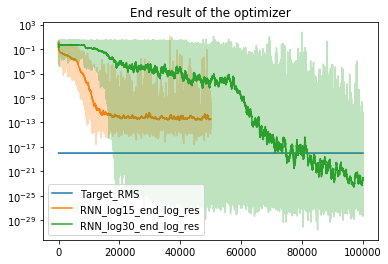

In [17]:
draw_convergence('Target_RMS', 'RNN_log15_end_log_res', 'RNN_log30_end_log_res')

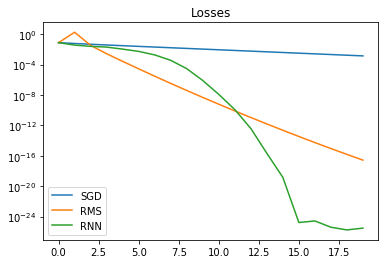

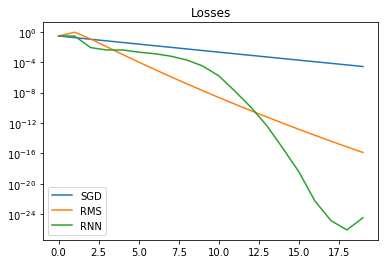

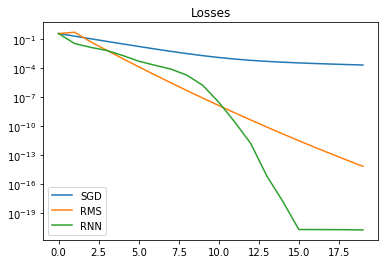

In [18]:
graph_optimizers(sgd_losses, rms_losses, rnn_losses)

We concluded the last episode by declaring victory over RMSProp ... but is it the best we can do ?

### How about actually finding 0 ?
To do that we need to define what is 0 in our context.  
It turns out Numpy offers an easy way to do that :

In [19]:
print(np.finfo(np.float32).tiny)

1.1754944e-38


Now that we know what's our next target, let's give another look to the graph of convergences :

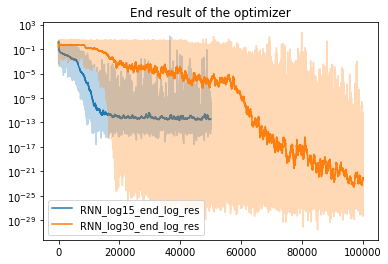

In [20]:
draw_convergence('RNN_log15_end_log_res', 'RNN_log30_end_log_res')

The obvious way to improve our RNN_log optimizer would be to continue the trend and try RNN_log50, however we can already see that the RNN_log30 had hard time starting it's convergence, so let's try to see if we can pinpoint what is the exact range of gradient we need to cast to [-1, 1] in the preprocessing of our RNN when we reach y = 1e-38.  
We might even be able to explain why RNN_log15 and RNN_log30 both seems to be hitting a floor at respectively 1e-14 and 1e-28

In [21]:
# What's the log(gradient) when y = 1e-14, 1e-28 or 1 ?  y = x**2 so y' = 2x = 2*(y**0.5)
print("log_gradient for 1e-14 : ", np.log(2*(1e-14**0.5)))
print("log_gradient for 1e-28 : ", np.log(2*(1e-28**0.5)))
print("log_gradient for 1e-38 : ", np.log(2*(1e-38**0.5)))

log_gradient for 1e-14 :  -15.424948470398375
log_gradient for 1e-28 :  -31.543044121356694
log_gradient for 1e-38 :  -43.055969586326924


Bingo!
The floor that RNN_log15 is hitting (y = 1e-14) corresponds to when the log(gradient) of x reaches -15. Same for RNN_log15. So it looks like we need to go for -43 as our next min_log_gradient

In [22]:
def g_rnn_log43(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  
  # Casting of gradients from [exp(-43), 1] to [0, 1] and [-1, -exp(-43)] to [-1, 0]
  min_log_gradient = -43
  log_gradients = tf.log(tf.abs(gradients) + np.exp(min_log_gradient))
  sign_gradients = tf.sign(gradients)
  trans_gradients = tf.multiply(sign_gradients,((log_gradients - min_log_gradient) / (- min_log_gradient)))

  if state is None:
      state = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
  update, state = cell(trans_gradients, state)

  # Casting of output from [0, 1] to [exp(-43), 1]  and [-1, 0] to [-1, -exp(-43)]
  abs_update = tf.abs(update)
  sign_update = tf.sign(update)
  update = tf.multiply(sign_update, tf.exp(abs_update * (- min_log_gradient) + min_log_gradient))
  return tf.squeeze(update, axis=[1]), state

rnn_losses = learn(g_rnn_log43)
log_loss = tf.log(rnn_losses[-1])
apply_update = optimize(log_loss, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
for it in range(50001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 5000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    average_log_result = '{:.2f}'.format(np.log10(list_result[-5000:]).mean())
    print_dict('it', 'optim_result', 'average_log_result')

# Let's store the convergence for later comparison
RNN_log43_end_log_res = list_result

{'it': 0, 'optim_result': '3.46E-01', 'average_log_result': '-0.46'}
{'it': 5000, 'optim_result': '6.89E-01', 'average_log_result': '-0.34'}
{'it': 10000, 'optim_result': '7.06E-01', 'average_log_result': '-0.33'}
{'it': 15000, 'optim_result': '1.52E-01', 'average_log_result': '-0.34'}
{'it': 20000, 'optim_result': '1.37E-01', 'average_log_result': '-0.34'}
{'it': 25000, 'optim_result': '7.43E-03', 'average_log_result': '-0.33'}
{'it': 30000, 'optim_result': '1.34E-01', 'average_log_result': '-0.33'}
{'it': 35000, 'optim_result': '6.45E-03', 'average_log_result': '-0.34'}
{'it': 40000, 'optim_result': '1.14E-01', 'average_log_result': '-0.33'}
{'it': 45000, 'optim_result': '5.46E-02', 'average_log_result': '-0.34'}
{'it': 50000, 'optim_result': '3.82E-01', 'average_log_result': '-0.34'}


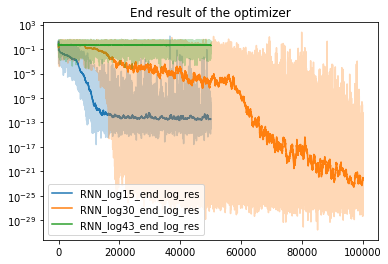

In [23]:
draw_convergence('RNN_log15_end_log_res', 'RNN_log30_end_log_res', 'RNN_log43_end_log_res')

The RNN is having trouble kick starting the convergence. The result is the same for RNN_log40, so we need some other way that extends the range of log(gradients) being correctly interpreted without completely freezing the convergence.
#### Variable gradient casting
The approach proposed below adapts the gradient range during the optimization, gradually lowering the floor of log(gradients) as the RNN gets more precise. 

In [24]:
class Log_casting:
  ### Class used to cast logarithmically vectors from a variable range of scales below one to [-1, 1]
  
  def __init__(self, init):
    # scalar of the minimum log(gradient) encountered, initialized with init
    self.min_log_value = tf.Variable(float(init), name="min_log_value", trainable=False)
    # vector identity multiplied by min_log_value, initialized as None
    self.min_log = None
  
  def update_min_log(self, vector):
    # This method is called at each iteration of the meta optimizer to adapt the min_log_value based on the
    # last gradient (iteration 20) returned by the learn2 function (defined below)
    log_vector = tf.log(tf.abs(vector) + 1e-38)
    # update proposal based on the gradient, the factor 0.01 is to avoid confusing the RNN with a sudden big shift
    update_proposal = 0.01*tf.reduce_min(log_vector) + 0.99*self.min_log_value
    # the update is applied only if it is lower than the current value
    new_value = tf.assign(self.min_log_value, tf.minimum(update_proposal, self.min_log_value))
    return new_value
  
  def preprocess(self, gradients):
    # Casting of gradients from [exp(min_log_value), 1] to [0, 1] and [-1, -exp(min_log_value)] to [-1, 0]
    self.min_log = tf.ones_like(gradients, name='MIN_LOG')*self.min_log_value
    log_gradients = tf.log(tf.abs(gradients) + 1e-38)
    sign_gradients = tf.sign(gradients)
    inputs = tf.multiply(sign_gradients,((log_gradients - self.min_log) / (- self.min_log)))
    return inputs
  
  def postprocess(self, outputs):
    # Casting back RNN output from [0, 1] to [exp(min_log_value), 1] and [-1, 0] to [-1, -exp(min_log_value)] 
    self.min_log = tf.ones_like(outputs, name='MIN_LOG')*self.min_log_value
    abs_outputs = tf.abs(outputs)
    sign_outputs = tf.sign(outputs)
    update = tf.multiply(sign_outputs, tf.exp(abs_outputs * (- self.min_log) + self.min_log))
    return update

def learn2(optimizer):
  losses = []
  x = initial_pos
  state = None
  # The loop below unrolls the 20 steps of the optimizer into a single tensorflow graph
  for _ in range(TRAINING_STEPS):
    loss = quadratic(x)
    losses.append(loss)
    grads, = tf.gradients(loss, x)
    update, state = optimizer(grads, state)
    x += update
  return losses, grads # the last gradient is added to the ouptut for use by Log_casting

In [25]:
Log_casting_ = Log_casting(-5) # initializes our "log caster"

def g_rnn_logv(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
  
  inputs = Log_casting_.preprocess(gradients)
  outputs, state = cell(inputs, state)
  update = Log_casting_.postprocess(outputs)
  
  return tf.squeeze(update, axis=[1]), state

rnn_losses, grads = learn2(g_rnn_logv) # grads output added for use by log_casting
log_loss = tf.log(rnn_losses[-1] + 1e-37) # residual added to prevent a log(0)... the price of success
apply_update = optimize(log_loss, learning_rate=0.0003)
# operation below added to gradually adapt the min_log value to the lowest gardient
update_log_casting = Log_casting_.update_min_log(grads)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(100001):
  errors, _, min_log = sess.run([rnn_losses, apply_update, update_log_casting])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-38).sum()/20)
  if it % 10000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-10000:] + 1e-38).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    min_log = '{:.2f}'.format(min_log)
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res', 'min_log')

RNN_logv_end_log_res = list_result

{'it': 0, 'optim_result': '8.77E-02', 'av_log_res': '-1.06', 'av_sum_log_res': '-0.80', 'min_log': '-5.00'}
{'it': 10000, 'optim_result': '1.21E-10', 'av_log_res': '-6.69', 'av_sum_log_res': '-2.88', 'min_log': '-18.79'}
{'it': 20000, 'optim_result': '3.75E-16', 'av_log_res': '-14.61', 'av_sum_log_res': '-4.30', 'min_log': '-29.93'}
{'it': 30000, 'optim_result': '2.83E-19', 'av_log_res': '-19.55', 'av_sum_log_res': '-5.34', 'min_log': '-35.91'}
{'it': 40000, 'optim_result': '6.01E-28', 'av_log_res': '-21.24', 'av_sum_log_res': '-6.04', 'min_log': '-39.13'}
{'it': 50000, 'optim_result': 'NAN', 'av_log_res': 'nan', 'av_sum_log_res': 'nan', 'min_log': 'nan'}
{'it': 60000, 'optim_result': 'NAN', 'av_log_res': 'nan', 'av_sum_log_res': 'nan', 'min_log': 'nan'}
{'it': 70000, 'optim_result': 'NAN', 'av_log_res': 'nan', 'av_sum_log_res': 'nan', 'min_log': 'nan'}
{'it': 80000, 'optim_result': 'NAN', 'av_log_res': 'nan', 'av_sum_log_res': 'nan', 'min_log': 'nan'}
{'it': 90000, 'optim_result': 'NA

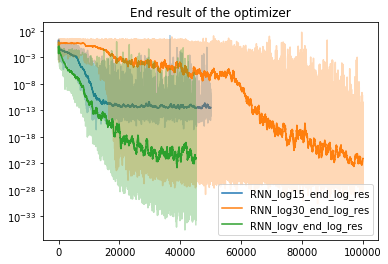

In [26]:
draw_convergence('RNN_log15_end_log_res', 'RNN_log30_end_log_res', 'RNN_logv_end_log_res')

So, on the plus side, the convergence is initially faster. We also seem to have removed the barrier preventing the RNN going lower than 1e-28. This allows the average result to continue improving, albeit very slowly.  
On the minus side, well, we are still nowhere near 0 (ie 1e-38) on average.
Before exploring new RNN configurations, let's try one last trick : instead of minimizing the log of the last result, we can minimize the sum of log of all the iteration.

In [27]:
def optimize(loss, learning_rate=0.1):
  # "Meta optimizer" to be applied on the RNN defined above
  optimizer = tf.train.AdamOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  clipped_gradients, _ = tf.clip_by_global_norm(gradients, 1.)
  checked_gradients = []
  # The following loop is to remove any NaNs from the gradient as it would be introduced
  # in the RNN weights and everything would stop working
  for g in clipped_gradients:
    checked_g = tf.where(tf.is_nan(g), tf.zeros_like(g), g)
    checked_gradients = checked_gradients + [checked_g]
  return optimizer.apply_gradients(zip(checked_gradients, v))

In [28]:
rnn_losses, grads = learn2(g_rnn_logv)
sum_log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-38)))
apply_update = optimize(sum_log_losses, learning_rate=0.0003)
update_log_casting = Log_casting_.update_min_log(grads)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(100001):
  errors, _, min_log = sess.run([rnn_losses, apply_update, update_log_casting])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-38).sum()/20)
  if it % 10000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-10000:] + 1e-38).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    min_log = '{:.2f}'.format(min_log)
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res', 'min_log')

RNN_logv_sum_log_res = list_result

{'it': 0, 'optim_result': '2.74E-01', 'av_log_res': '-0.56', 'av_sum_log_res': '-0.68', 'min_log': '-5.00'}
{'it': 10000, 'optim_result': '8.49E-19', 'av_log_res': '-8.98', 'av_sum_log_res': '-4.14', 'min_log': '-22.92'}
{'it': 20000, 'optim_result': '1.03E-28', 'av_log_res': '-20.57', 'av_sum_log_res': '-6.48', 'min_log': '-36.41'}
{'it': 30000, 'optim_result': '3.20E-29', 'av_log_res': '-23.79', 'av_sum_log_res': '-7.62', 'min_log': '-41.01'}
{'it': 40000, 'optim_result': '2.48E-29', 'av_log_res': '-23.91', 'av_sum_log_res': '-8.19', 'min_log': '-43.37'}
{'it': 50000, 'optim_result': '3.44E-28', 'av_log_res': 'nan', 'av_sum_log_res': 'nan', 'min_log': '-45.25'}
{'it': 60000, 'optim_result': '1.14E-34', 'av_log_res': '-24.31', 'av_sum_log_res': 'nan', 'min_log': '-46.81'}
{'it': 70000, 'optim_result': '2.80E-25', 'av_log_res': '-24.94', 'av_sum_log_res': 'nan', 'min_log': '-48.30'}
{'it': 80000, 'optim_result': '1.18E-30', 'av_log_res': '-25.28', 'av_sum_log_res': 'nan', 'min_log': '-

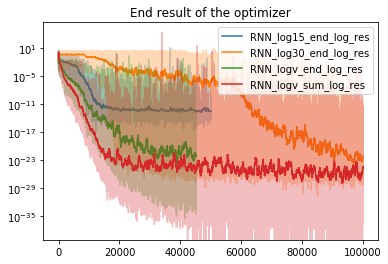

In [29]:
draw_convergence('RNN_log15_end_log_res', 'RNN_log30_end_log_res', 'RNN_logv_end_log_res',
                 'RNN_logv_sum_log_res')

We are getting closer. Let's have a look at what the convergence looks like.

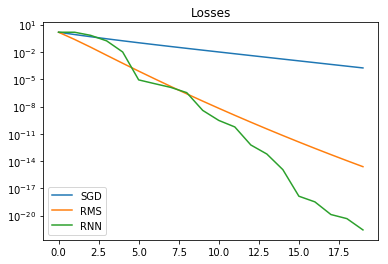

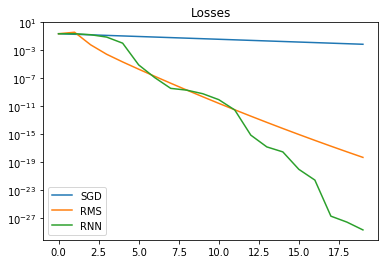

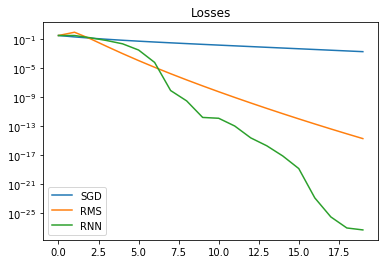

In [30]:
graph_optimizers(sgd_losses, rms_losses, rnn_losses)

Better, but we are still far from 1e-38
#### Scale Invariant RNN
The first problem we highlighted is that we are trying to design a RNN that works as well at y=1 as at y=1e-38, with gradient varying between 1 and exp(-43)≈1e-19 (I should mention that this python confusing convention of writting small numbers like 10-5 with 1e-5 is most unfortunate in our context).  
The different implementations of logaritmic preprocessing of the gradients proposed above sort of address the problem by rescaling this huge variation of scale into a linear segment between 0 and 1 so that it is more or less interpretable by the RNN, but it's never truly scale invariant.  
There is probably a much better implementation of this idea of logaritmic preprocessing, but instead of sinking more time into fine tuning this (or digging into Deepmind's code to see how they cracked this :-), we can try a simpler approach : since the RNN is being fed the past 20 inputs, why not feed it only the ratios of gradients between one step and the next and let it deal with it.  
It's actually the first idea I tried. However, I was using the direct result of the RNN as the function to be minimized, and as we have seen, this leads to vanishing gradient if you're not applying log to the function.

In [31]:
def g_rnn_div(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state_nn = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    state = [state_nn, gradients]
  inputs = tf.divide(gradients, tf.abs(state[1]) + 1e-38)
  update, state[0] = cell(inputs, state[0])
  outputs = tf.multiply(update, tf.abs(state[1]) + 1e-38)
  state[1] = gradients
  return tf.squeeze(outputs, axis=[1]), state

rnn_losses = learn(g_rnn_div)
end_loss = rnn_losses[-1]
apply_update = optimize(end_loss, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(50001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-38).sum()/20)
  if it % 5000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-5000:] + 1e-38).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res')

RNN_div_end_res = list_result

{'it': 0, 'optim_result': '1.57E-02', 'av_log_res': '-1.80', 'av_sum_log_res': '-1.09'}
{'it': 2000, 'optim_result': '1.40E-06', 'av_log_res': '-5.47', 'av_sum_log_res': '-2.85'}
{'it': 4000, 'optim_result': '9.07E-07', 'av_log_res': '-5.34', 'av_sum_log_res': '-2.79'}
{'it': 6000, 'optim_result': '1.14E-04', 'av_log_res': '-5.77', 'av_sum_log_res': '-2.83'}
{'it': 8000, 'optim_result': '1.13E-07', 'av_log_res': '-6.48', 'av_sum_log_res': '-2.93'}
{'it': 10000, 'optim_result': '4.20E-07', 'av_log_res': '-6.62', 'av_sum_log_res': '-3.01'}
{'it': 12000, 'optim_result': '2.17E-07', 'av_log_res': '-6.77', 'av_sum_log_res': '-3.06'}
{'it': 14000, 'optim_result': '1.08E-07', 'av_log_res': '-6.73', 'av_sum_log_res': '-3.08'}
{'it': 16000, 'optim_result': '3.90E-07', 'av_log_res': '-7.23', 'av_sum_log_res': '-3.14'}
{'it': 18000, 'optim_result': '6.68E-08', 'av_log_res': '-7.00', 'av_sum_log_res': '-3.15'}
{'it': 20000, 'optim_result': '5.19E-08', 'av_log_res': '-7.51', 'av_sum_log_res': '-3.1

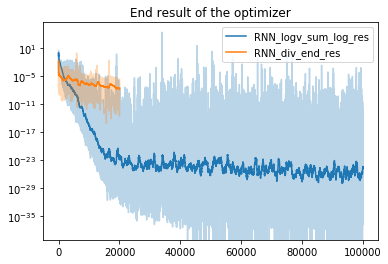

In [32]:
draw_convergence('RNN_logv_sum_log_res', 'RNN_div_end_res')

In [33]:
rnn_losses = learn(g_rnn_div)
sum_log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-38)))
apply_update = optimize(sum_log_losses, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(100001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-38).sum()/20)
  if it % 10000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-10000:] + 1e-38).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res')

RNN_div_sum_log_res = list_result

{'it': 0, 'optim_result': '4.24E-03', 'av_log_res': '-2.37', 'av_sum_log_res': '-1.16'}
{'it': 10000, 'optim_result': '7.38E-23', 'av_log_res': '-19.32', 'av_sum_log_res': '-9.06'}
{'it': 20000, 'optim_result': '4.24E-22', 'av_log_res': '-26.86', 'av_sum_log_res': '-10.87'}
{'it': 30000, 'optim_result': '1.53E-29', 'av_log_res': '-27.38', 'av_sum_log_res': '-11.56'}
{'it': 40000, 'optim_result': '2.48E-34', 'av_log_res': '-28.28', 'av_sum_log_res': '-12.00'}
{'it': 50000, 'optim_result': '5.84E-32', 'av_log_res': '-31.26', 'av_sum_log_res': '-12.58'}
{'it': 60000, 'optim_result': '3.52E-31', 'av_log_res': '-31.12', 'av_sum_log_res': '-12.95'}
{'it': 70000, 'optim_result': '3.88E-35', 'av_log_res': '-31.16', 'av_sum_log_res': '-13.20'}
{'it': 80000, 'optim_result': '0.00E+00', 'av_log_res': 'nan', 'av_sum_log_res': 'nan'}
{'it': 90000, 'optim_result': '2.72E-32', 'av_log_res': '-32.17', 'av_sum_log_res': 'nan'}
{'it': 100000, 'optim_result': '6.23E-37', 'av_log_res': '-33.27', 'av_sum_l

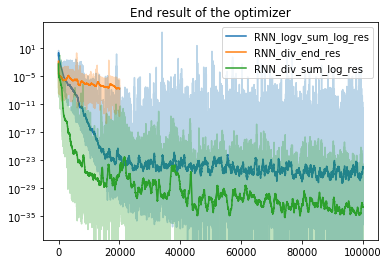

In [34]:
draw_convergence('RNN_logv_sum_log_res', 'RNN_div_end_res', 'RNN_div_sum_log_res')

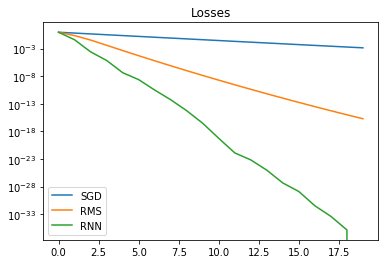

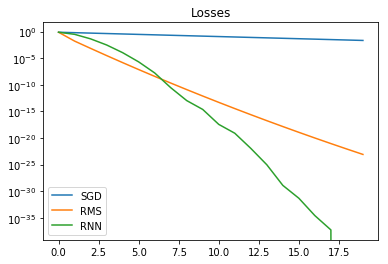

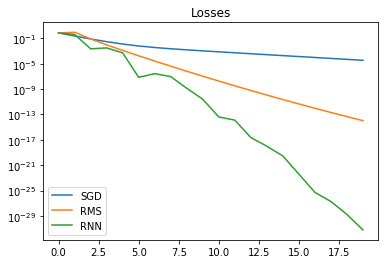

In [35]:
graph_optimizers(sgd_losses, rms_losses, rnn_losses)

To be noted : the implementation above devides the gradient by the norm of the previous gradient. Dividing by the gradients yields more or less the same results

In [36]:
def optimize(loss, learning_rate=0.1):
  # "Meta optimizer" to be applied on the RNN defined above
  optimizer = tf.train.AdamOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  clipped_gradients, _ = tf.clip_by_global_norm(gradients, 1.)
  checked_gradients = []
  for g in clipped_gradients:
    checked_g = tf.where(tf.is_nan(g), tf.zeros_like(g), g)
    checked_gradients = checked_gradients + [checked_g]
  return optimizer.apply_gradients(zip(checked_gradients, v))

In [37]:
Log_casting_ = Log_casting(-5)

def g_rnn_logdiv(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state_nn = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    state = [state_nn, gradients, gradients]
  inputs_ = tf.divide(gradients, tf.abs(state[1]) + 1e-38)
  inputs = Log_casting_.preprocess(inputs_)
  outputs, state[0] = cell(inputs, state[0])
  outputs_ = Log_casting_.postprocess(outputs)
  update = tf.multiply(outputs_, tf.abs(state[1]) + 1e-38)
  state[1] = gradients
  state[2] = inputs_
  return tf.squeeze(update, axis=[1]), state

def learn3(optimizer):
  losses = []
  x = initial_pos
  state = None
  for _ in range(TRAINING_STEPS):
    loss = quadratic(x)
    losses.append(loss)
    grads, = tf.gradients(loss, x)
    update, state = optimizer(grads, state)
    x += update
  return losses, state[2] # the last RNN input is added to the ouptut for use by Log_casting

rnn_losses, RNN_inputs = learn3(g_rnn_logdiv) # grads output added for use by log_casting
sum_log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-38)))
apply_update = optimize(sum_log_losses, learning_rate=0.0003)
# the operation below gradually adapts the min_log value to the lowest gardient ratio
update_log_casting = Log_casting_.update_min_log(RNN_inputs)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(100001):
  errors, _, min_log = sess.run([rnn_losses, apply_update, update_log_casting])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-38).sum()/20)
  if it % 10000 == 0 :
    list_result_ = list_result[~np.isnan(list_result)]
    list_sum_log_res_ = list_sum_log_res[~np.isnan(list_sum_log_res)]
    NaN = list_result.size - list_result_.size
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-10000:] + 1e-38).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    min_log = '{:.2f}'.format(min_log)
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res', 'min_log', 'NaN')

RNN_logdiv_sum_log_res = list_result

{'it': 0, 'optim_result': '5.29E-01', 'av_log_res': '-0.28', 'av_sum_log_res': '-0.28', 'min_log': '-5.00', 'NaN': 0}
{'it': 10000, 'optim_result': '9.96E-21', 'av_log_res': '-15.31', 'av_sum_log_res': '-7.19', 'min_log': '-6.04', 'NaN': 0}
{'it': 20000, 'optim_result': '1.43E-32', 'av_log_res': '-25.34', 'av_sum_log_res': '-9.42', 'min_log': '-7.10', 'NaN': 0}
{'it': 30000, 'optim_result': '9.24E-35', 'av_log_res': '-33.71', 'av_sum_log_res': '-11.50', 'min_log': '-7.63', 'NaN': 0}
{'it': 40000, 'optim_result': '1.07E-37', 'av_log_res': '-36.05', 'av_sum_log_res': '-12.99', 'min_log': '-8.11', 'NaN': 0}
{'it': 50000, 'optim_result': '0.00E+00', 'av_log_res': '-36.52', 'av_sum_log_res': '-14.12', 'min_log': '-8.46', 'NaN': 0}
{'it': 60000, 'optim_result': '0.00E+00', 'av_log_res': '-36.84', 'av_sum_log_res': '-15.04', 'min_log': '-8.77', 'NaN': 0}
{'it': 70000, 'optim_result': '0.00E+00', 'av_log_res': 'nan', 'av_sum_log_res': 'nan', 'min_log': '-9.00', 'NaN': 1}
{'it': 80000, 'optim_r

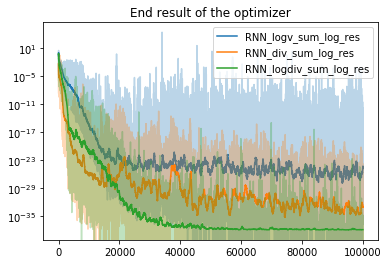

In [38]:
draw_convergence('RNN_logv_sum_log_res', 'RNN_div_sum_log_res', 'RNN_logdiv_sum_log_res')

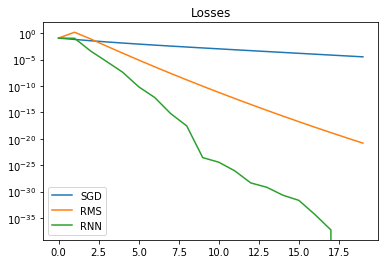

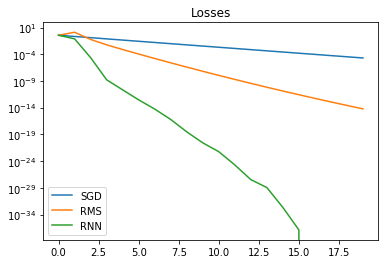

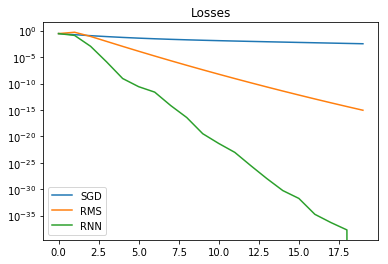

In [39]:
graph_optimizers(sgd_losses, rms_losses, rnn_losses)

In [40]:
def g_rnn_log7div(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state_nn = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    state = [state_nn, gradients]
  inputs_ = tf.divide(gradients, tf.abs(state[1]) + 1e-37)
  
  # Casting of inputs from [exp(-43), 1] to [0, 1] and [-1, -exp(-43)] to [-1, 0]
  min_log_gradient = -7
  log_inputs_ = tf.log(tf.abs(inputs_) + np.exp(min_log_gradient-2))
  sign_gradients = tf.sign(gradients)
  inputs = tf.multiply(sign_gradients,((log_inputs_ - min_log_gradient) / (- min_log_gradient)))
  
  outputs, state[0] = cell(inputs, state[0])
  
  # Casting of output from [0, 1] to [exp(-43), 1]  and [-1, 0] to [-1, -exp(-43)]
  abs_outputs = tf.abs(outputs)
  sign_outputs = tf.sign(outputs)
  outputs_ = tf.multiply(sign_outputs, tf.exp(abs_outputs * (- min_log_gradient) + min_log_gradient))

  update = tf.multiply(outputs_, tf.abs(state[1]) + 1e-37)
  state[1] = gradients
  return tf.squeeze(update, axis=[1]), state

rnn_losses = learn(g_rnn_logdiv)
sum_log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-37)))
apply_update = optimize(sum_log_losses, learning_rate=0.0001)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(100001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-37).sum()/20)
  if it % 10000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-10000:] + 1e-37).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res')

RNN_log7div_sum_log_res = list_result

{'it': 0, 'optim_result': '2.61E+00', 'av_log_res': '0.42', 'av_sum_log_res': '0.13'}
{'it': 10000, 'optim_result': '5.05E-11', 'av_log_res': '-7.17', 'av_sum_log_res': '-3.41'}
{'it': 20000, 'optim_result': '1.71E-25', 'av_log_res': '-16.89', 'av_sum_log_res': '-5.69'}
{'it': 30000, 'optim_result': '1.32E-20', 'av_log_res': '-20.86', 'av_sum_log_res': '-7.10'}
{'it': 40000, 'optim_result': '4.72E-31', 'av_log_res': '-21.88', 'av_sum_log_res': '-7.95'}
{'it': 50000, 'optim_result': '6.30E-25', 'av_log_res': '-24.18', 'av_sum_log_res': '-8.67'}
{'it': 60000, 'optim_result': '1.90E-28', 'av_log_res': '-26.30', 'av_sum_log_res': '-9.37'}
{'it': 70000, 'optim_result': '7.08E-27', 'av_log_res': '-27.97', 'av_sum_log_res': '-9.99'}
{'it': 80000, 'optim_result': '1.86E-31', 'av_log_res': '-28.98', 'av_sum_log_res': '-10.53'}
{'it': 90000, 'optim_result': '2.64E-34', 'av_log_res': '-29.87', 'av_sum_log_res': '-10.98'}
{'it': 100000, 'optim_result': '1.27E-32', 'av_log_res': '-30.58', 'av_sum_l

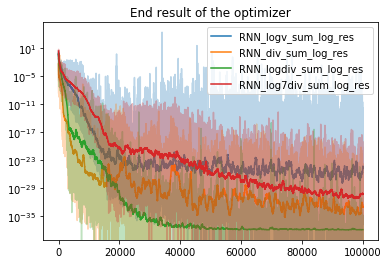

In [41]:
draw_convergence('RNN_logv_sum_log_res', 'RNN_div_sum_log_res', 'RNN_logdiv_sum_log_res', 'RNN_log7div_sum_log_res')